In [22]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import re
import faiss
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [23]:
# Настройка отображения
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (12, 8)

In [24]:
# Отключаем предупреждения
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
print("Библиотеки загружены и настроены")

Библиотеки загружены и настроены


In [25]:
# Загрузка и анализ данных
def load_data(file_path):
    """Загрузка TSV файла с данными"""
    print(f" Загрузка данных из {file_path}...")
    
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'label'])
        print(f"Загружено {len(df)} примеров")
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return [], []
    
    # Очистка текстов
    def clean_text(text):
        if isinstance(text, str):
            text = re.sub(r'\s+', ' ', text).strip().lower()
            return text
        return ""
    
    df['text_clean'] = df['text'].apply(clean_text)
    df = df[df['text_clean'].str.len() > 0]
    
    print(f" Статистика датасета:")
    print(f"   Примеров: {len(df)}")
    print(f"   Уникальных классов: {df['label'].nunique()}")
    print(f"   Средняя длина текста: {df['text_clean'].str.len().mean():.1f} символов")
    
    return df['text_clean'].tolist(), df['label'].tolist(), df

# Загрузка данных
texts, labels, df = load_data('data/dataset_test.tsv')

# Показываем первые примеры
print("\n Первые 10 примеров данных:")
display(df.head(10))

 Загрузка данных из data/dataset_test.tsv...
Загружено 883 примеров
 Статистика датасета:
   Примеров: 883
   Уникальных классов: 141
   Средняя длина текста: 29.7 символов

 Первые 10 примеров данных:


,text,label,text_clean
0,как получить справку,statement_general,как получить справку
1,мне нужна справка,statement_general,мне нужна справка
2,справка студента эф петь,conform,справка студента эф петь
3,справка студента фф оформлять,conform,справка студента фф оформлять
4,как мне заказать справка об обучении,conform,как мне заказать справка об обучении
5,справка студента фит оформить,conform,справка студента фит оформить
6,справка студента как мне заказать,conform,справка студента как мне заказать
7,справка об обучении получать,conform,справка об обучении получать
8,справка студента ммф оформлять,conform,справка студента ммф оформлять
9,справка о обучении как мне заказать,conform,справка о обучении как мне заказать


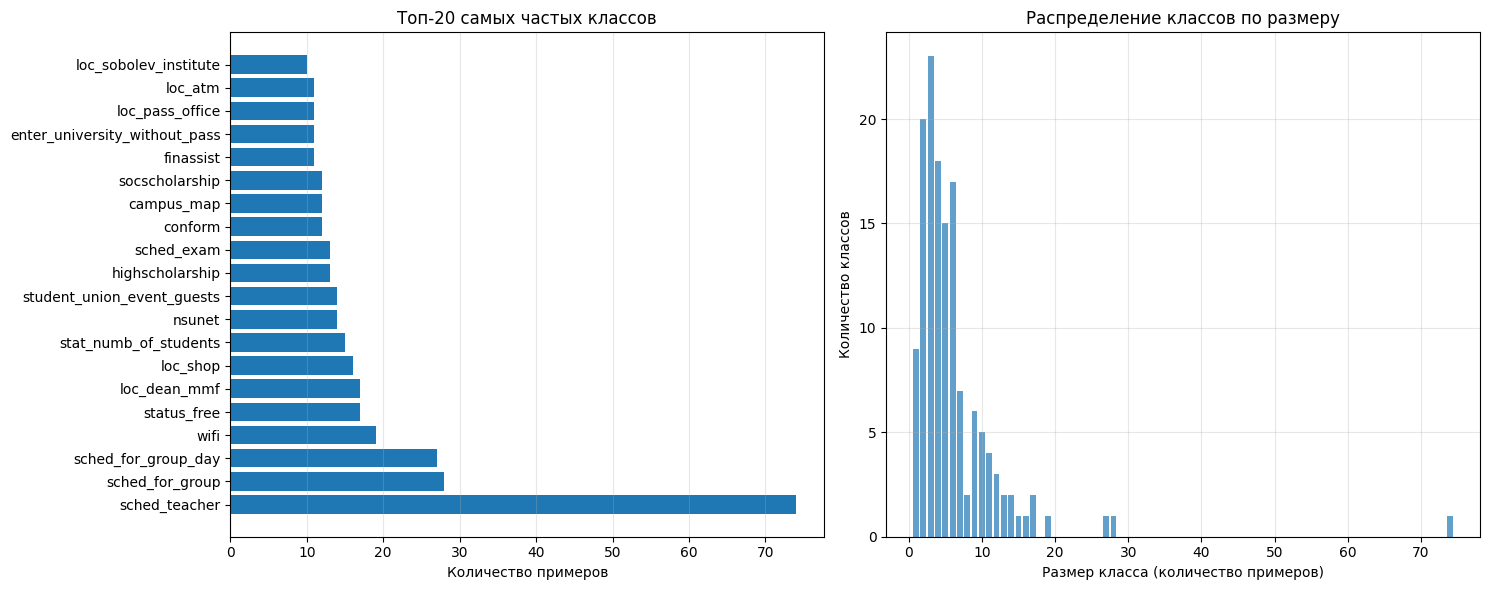

 Статистика распределения классов:
   Маленькие (1-3 примера): 52 классов
   Средние (4-10 примеров): 70 классов
   Большие (10+ примеров): 19 классов
   Всего классов: 141


In [26]:
# Визуализация распределения классов
def plot_class_distribution(labels, top_n=20):
    """Визуализация распределения классов"""
    label_counts = Counter(labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Топ-N самых частых классов
    top_labels = label_counts.most_common(top_n)
    labels_list, counts = zip(*top_labels)
    
    ax1.barh(range(len(labels_list)), counts)
    ax1.set_yticks(range(len(labels_list)))
    ax1.set_yticklabels(labels_list)
    ax1.set_xlabel('Количество примеров')
    ax1.set_title(f'Топ-{top_n} самых частых классов')
    ax1.grid(axis='x', alpha=0.3)
    
    # Распределение по размеру классов
    size_counts = Counter(label_counts.values())
    sizes = list(size_counts.keys())
    class_counts = list(size_counts.values())
    
    ax2.bar(sizes, class_counts, alpha=0.7)
    ax2.set_xlabel('Размер класса (количество примеров)')
    ax2.set_ylabel('Количество классов')
    ax2.set_title('Распределение классов по размеру')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    small_classes = sum(1 for count in label_counts.values() if count <= 3)
    medium_classes = sum(1 for count in label_counts.values() if 4 <= count <= 10)
    large_classes = sum(1 for count in label_counts.values() if count > 10)
    
    print(" Статистика распределения классов:")
    print(f"   Маленькие (1-3 примера): {small_classes} классов")
    print(f"   Средние (4-10 примеров): {medium_classes} классов")
    print(f"   Большие (10+ примеров): {large_classes} классов")
    print(f"   Всего классов: {len(label_counts)}")

plot_class_distribution(labels)

In [27]:
# Класс BERT+KNN классификатора
class BERTKNNClassifier:
    def __init__(self, model_name='cointegrated/rubert-tiny2'):
        self.model_name = model_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = None
        self.model = None
        self.index = None
        self.label_encoder = LabelEncoder()
        self.train_embeddings = None
        self.train_labels = None
        self.train_texts = None
        
        print(f"Используется устройство: {self.device}")
    
    def load_model(self):
        """Загрузка BERT модели"""
        print(f"Загрузка модели {self.model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        print("Модель загружена")
    
    def get_embeddings(self, texts, batch_size=16, show_progress=True):
        """Получение BERT эмбеддингов"""
        if self.model is None:
            self.load_model()
            
        embeddings = []
        texts_iter = texts
        
        
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                inputs = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(self.device)
                
                outputs = self.model(**inputs)
                # Mean pooling
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                embeddings.append(batch_embeddings)
        
        return np.vstack(embeddings)
    
    def build_index(self, embeddings):
        """Построение FAISS индекса"""
        print("Построение векторного индекса...")
        
        dimension = embeddings.shape[1]
        faiss.normalize_L2(embeddings)
        
        # Используем IndexFlatIP для косинусного сходства
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(embeddings)
        
        print(f"FAISS индекс построен ({self.index.ntotal} векторов, размерность: {dimension})")
    
    def fit(self, texts, labels, min_examples=2):
        """Обучение классификатора"""
        print("Начало обучения...")
        
        # Сохраняем тексты для демонстрации
        self.train_texts = texts
        
        # Фильтрация малых классов
        if min_examples > 1:
            label_counts = Counter(labels)
            adequate_labels = {label for label, count in label_counts.items() if count >= min_examples}
            
            filtered_texts = []
            filtered_labels = []
            for text, label in zip(texts, labels):
                if label in adequate_labels:
                    filtered_texts.append(text)
                    filtered_labels.append(label)
            
            print(f"После фильтрации: {len(filtered_texts)} примеров, {len(adequate_labels)} классов")
            texts, labels = filtered_texts, filtered_labels
        
        # Кодирование меток
        self.train_labels = self.label_encoder.fit_transform(labels)
        print(f"Классы для обучения: {list(self.label_encoder.classes_)}")
        
        # Получение эмбеддингов
        self.train_embeddings = self.get_embeddings(texts)
        print(f"Размерность эмбеддингов: {self.train_embeddings.shape}")
        
        # Построение индекса
        self.build_index(self.train_embeddings)
        
        print("Обучение завершено!")
    
    def predict(self, texts, k=5, strategy='weighted', show_progress=True):
        """Предсказание с различными стратегиями"""
        predictions = []
        confidences = []
        texts_iter = texts
        
        if show_progress:
            texts_iter = tqdm(texts, desc="Предсказание")
        
        for text in texts_iter:
            # Получаем эмбеддинг
            text_embedding = self.get_embeddings([text], show_progress=False)
            faiss.normalize_L2(text_embedding)
            
            # Поиск соседей
            distances, indices = self.index.search(text_embedding, k)
            similarities = 1 - distances[0]  # преобразуем в схожесть
            
            # Получаем метки соседей
            neighbor_labels = self.train_labels[indices[0]]
            neighbor_text_labels = self.label_encoder.inverse_transform(neighbor_labels)
            
            if strategy == 'weighted':
                # Взвешенное голосование
                votes = {}
                for label, similarity in zip(neighbor_text_labels, similarities):
                    votes[label] = votes.get(label, 0) + similarity
                
                predicted_label = max(votes.items(), key=lambda x: x[1])[0]
                confidence = votes[predicted_label] / sum(similarities) if sum(similarities) > 0 else 0.0
                
            elif strategy == 'majority':
                # Мажоритарное голосование
                most_common = Counter(neighbor_text_labels).most_common(1)[0]
                predicted_label = most_common[0]
                confidence = most_common[1] / k
                
            else:  # nearest
                # Ближайший сосед
                predicted_label = neighbor_text_labels[0]
                confidence = similarities[0]
            
            predictions.append(predicted_label)
            confidences.append(confidence)
        
        return predictions, confidences

print("Класс BERTKNNClassifier определен")

Класс BERTKNNClassifier определен


In [28]:
# Подготовка данных и обучение модели
print("Подготовка данных для обучения...")

# Разделение на train/test
split_idx = int(0.8 * len(texts))
train_texts, test_texts = texts[:split_idx], texts[split_idx:]
train_labels, test_labels = labels[:split_idx], labels[split_idx:]

print(f"Разделение данных:")
print(f"   Обучающая выборка: {len(train_texts)} примеров")
print(f"   Тестовая выборка: {len(test_texts)} примеров")

# Создание и обучение модели
classifier = BERTKNNClassifier()
classifier.fit(train_texts, train_labels, min_examples=2)

Подготовка данных для обучения...
Разделение данных:
   Обучающая выборка: 706 примеров
   Тестовая выборка: 177 примеров
Используется устройство: cpu
Начало обучения...
После фильтрации: 700 примеров, 113 классов
Классы для обучения: ['advice_learning', 'advice_okno', 'campus_map', 'conform', 'cvvr_define', 'diploma_red_def', 'dorm_enter_without_pass', 'dorm_guests', 'dorm_living', 'dorm_pets', 'dorm_price', 'dormcard_lost', 'enter_university_without_pass', 'events_define', 'exam_define', 'finassist', 'find_friends', 'grade_improve', 'grade_mistake', 'highscholarship', 'holidays_def', 'incomestat', 'list_orders', 'loc_accounting', 'loc_atm', 'loc_automationelectrometryinstitute', 'loc_cafeteria_new_building_general', 'loc_cafeteria_old_building', 'loc_cashbox', 'loc_chiminstitute', 'loc_clinic', 'loc_commissariat', 'loc_compcenter', 'loc_coworking', 'loc_cytologygeneticsinstitute', 'loc_dean_ef', 'loc_dean_fen', 'loc_dean_ff', 'loc_dean_fit', 'loc_dean_general', 'loc_dean_ggf', 'loc_d

In [29]:
# Демонстрация работы векторного индекса
def demonstrate_search(classifier, queries):
    """Демонстрация поиска похожих текстов"""
    print("🔍 ДЕМОНСТРАЦИЯ ПОИСКА ПО ВЕКТОРНОМУ ИНДЕКСУ")
    print("=" * 60)
    
    for query in queries:
        print(f"\nЗапрос: '{query}'")
        print("-" * 50)
        
        # Получаем эмбеддинг
        query_embedding = classifier.get_embeddings([query], show_progress=False)
        faiss.normalize_L2(query_embedding)
        
        # Ищем 5 ближайших соседей
        distances, indices = classifier.index.search(query_embedding, 5)
        
        print("Ближайшие соседи:")
        for i, (idx, distance) in enumerate(zip(indices[0], distances[0])):
            if idx < len(classifier.train_texts):
                similar_text = classifier.train_texts[idx]
                similar_label = classifier.label_encoder.inverse_transform([classifier.train_labels[idx]])[0]
                similarity = 1 - distance
                print(f"  {i+1}. [схожесть: {similarity:.3f}] {similar_label}: '{similar_text}'")

# Демонстрация поиска
demo_queries = ["как получить справку", "где находится автор", "до свидания"]
demonstrate_search(classifier, demo_queries)

🔍 ДЕМОНСТРАЦИЯ ПОИСКА ПО ВЕКТОРНОМУ ИНДЕКСУ

Запрос: 'как получить справку'
--------------------------------------------------
Ближайшие соседи:
  1. [схожесть: 0.020] statement_general: 'как получить справку'
  2. [схожесть: 0.180] incomestat: 'как мне заказать справка доходный'
  3. [схожесть: 0.219] incomestat: 'получать справка доходный'
  4. [схожесть: 0.236] conform: 'как мне заказать справка об обучении'
  5. [схожесть: 0.242] conform: 'справка об обучении получать'

Запрос: 'где находится автор'
--------------------------------------------------
Ближайшие соседи:
  1. [схожесть: 0.129] smalltalk_creator: 'автор расположен где'
  2. [схожесть: 0.132] smalltalk_creator: 'находится автор'
  3. [схожесть: 0.195] loc_library: 'расположен где библиотечка'
  4. [схожесть: 0.209] math_center_def: 'где лучшего всего покупать продукты'
  5. [схожесть: 0.216] smalltalk_creator: 'распологается где создатель'

Запрос: 'до свидания'
--------------------------------------------------
Ближайши

In [30]:
# Сравнение стратегий классификации
def compare_strategies(classifier, test_samples=50):
    """Сравнение различных стратегий KNN"""
    print("СРАВНЕНИЕ СТРАТЕГИЙ КЛАССИФИКАЦИИ")
    print("=" * 50)
    
    # Берем подмножество для быстрого тестирования
    test_subset = test_texts[:test_samples]
    true_labels = test_labels[:test_samples]
    
    strategies = {
        'k=1 (ближайший сосед)': {'k': 1, 'strategy': 'nearest'},
        'k=3 (мажоритарное)': {'k': 3, 'strategy': 'majority'},
        'k=5 (мажоритарное)': {'k': 5, 'strategy': 'majority'},
        'k=5 (взвешенное)': {'k': 5, 'strategy': 'weighted'}
    }
    
    results = {}
    
    for name, params in strategies.items():
        print(f"\n {name}:")
        predictions, confidences = classifier.predict(
            test_subset, 
            k=params['k'], 
            strategy=params['strategy'],
            show_progress=False
        )
        
        accuracy = accuracy_score(true_labels, predictions)
        results[name] = accuracy
        
        print(f"   Точность: {accuracy:.4f}")
        
        # Показываем несколько примеров
        print("   Примеры:")
        for i, (text, true, pred, conf) in enumerate(zip(test_subset[:3], true_labels[:3], predictions[:3], confidences[:3])):
            status = "Да" if true == pred else "Нет"
            print(f"      {status} '{text}'")
            print(f"          Истина: {true} → Предсказание: {pred} (уверенность: {conf:.3f})")
    
compare_strategies(classifier, test_samples=50)

СРАВНЕНИЕ СТРАТЕГИЙ КЛАССИФИКАЦИИ

 k=1 (ближайший сосед):
   Точность: 0.0000
   Примеры:
      Нет 'корпус административный этаж первый ресторан где есть'
          Истина: loc_cafeteria_new_building_1_etage → Предсказание: loc_cafeteria_old_building (уверенность: 0.259)
      Нет 'находится точка питания корпус административный 1 этаж'
          Истина: loc_cafeteria_new_building_1_etage → Предсказание: campus_map (уверенность: 0.337)
      Нет 'корпус новый этаж первый столовка расположен где'
          Истина: loc_cafeteria_new_building_1_etage → Предсказание: loc_cafeteria_old_building (уверенность: 0.238)

 k=3 (мажоритарное):
   Точность: 0.0000
   Примеры:
      Нет 'корпус административный этаж первый ресторан где есть'
          Истина: loc_cafeteria_new_building_1_etage → Предсказание: loc_cafeteria_old_building (уверенность: 1.000)
      Нет 'находится точка питания корпус административный 1 этаж'
          Истина: loc_cafeteria_new_building_1_etage → Предсказание: campus_

In [31]:
# Оценка модели на тестовой выборке
print("ТЕСТИРОВАНИЕ МОДЕЛИ НА ПОЛНОЙ ВЫБОРКЕ")
print("=" * 50)

# Предсказания с лучшей стратегией
predictions, confidences = classifier.predict(test_texts, k=5, strategy='weighted')

# Метрики качества
accuracy = accuracy_score(test_labels, predictions)
print(f"Общая точность: {accuracy:.4f}")

# Детальный отчет
print("\nДетальный отчет по классам:")
print(classification_report(test_labels, predictions, zero_division=0))

# Матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Берем только частые классы для матрицы ошибок
label_counts = Counter(test_labels)
common_labels = [label for label, count in label_counts.most_common(10)]  # топ-10 классов

mask = [label in common_labels for label in test_labels]
filtered_true = [label for i, label in enumerate(test_labels) if mask[i]]
filtered_pred = [label for i, label in enumerate(predictions) if mask[i]]

ТЕСТИРОВАНИЕ МОДЕЛИ НА ПОЛНОЙ ВЫБОРКЕ


Предсказание: 100%|██████████| 177/177 [00:01<00:00, 153.19it/s]

Общая точность: 0.0000

Детальный отчет по классам:
                                    precision    recall  f1-score   support

                        campus_map       0.00      0.00      0.00       0.0
                           conform       0.00      0.00      0.00       0.0
                     dormcard_lost       0.00      0.00      0.00       0.0
     enter_university_without_pass       0.00      0.00      0.00       0.0
                         finassist       0.00      0.00      0.00       0.0
                   highscholarship       0.00      0.00      0.00       0.0
                        incomestat       0.00      0.00      0.00       0.0
                           loc_atm       0.00      0.00      0.00       0.0
loc_cafeteria_new_building_1_etage       0.00      0.00      0.00       9.0
loc_cafeteria_new_building_2_etage       0.00      0.00      0.00       9.0
loc_cafeteria_new_building_3_etage       0.00      0.00      0.00       9.0
loc_cafeteria_new_building_4_etage 

ВИЗУАЛИЗАЦИЯ ВЕКТОРНЫХ ПРЕДСТАВЛЕНИЙ
Визуализация 51 текстов из 6 классов


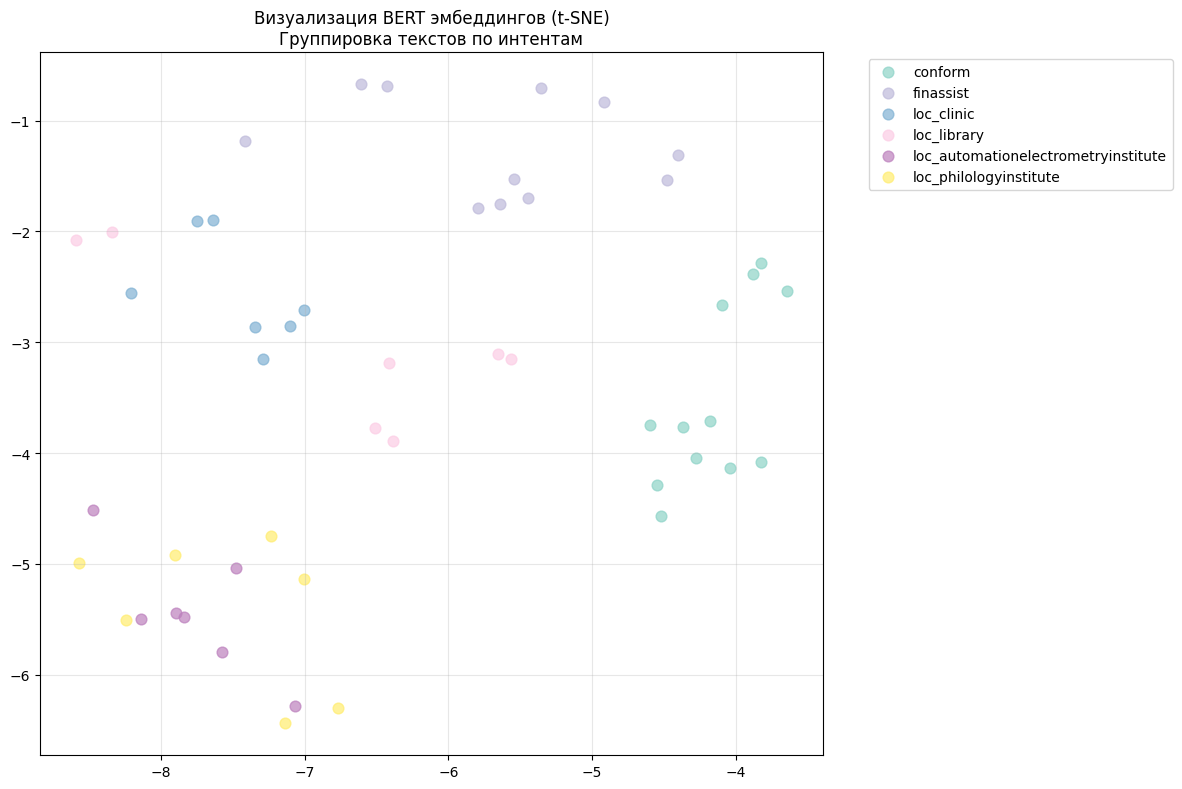

In [32]:
# Визуализация эмбеддингов
def visualize_embeddings(classifier, texts, labels, n_classes=8):
    """Визуализация BERT эмбеддингов в 2D пространстве"""
    print("ВИЗУАЛИЗАЦИЯ ВЕКТОРНЫХ ПРЕДСТАВЛЕНИЙ")
    print("=" * 50)
    
    # Берем наиболее частые классы
    label_counts = Counter(labels)
    top_classes = [label for label, _ in label_counts.most_common(n_classes)]
    
    # Фильтруем данные
    filtered_texts = []
    filtered_labels = []
    for text, label in zip(texts, labels):
        if label in top_classes:
            filtered_texts.append(text)
            filtered_labels.append(label)
    
    print(f"Визуализация {len(filtered_texts)} текстов из {len(top_classes)} классов")
    
    # Получаем эмбеддинги
    embeddings = classifier.get_embeddings(filtered_texts, show_progress=True)
    
    # Уменьшаем размерность с помощью t-SNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_classes)))
    
    for i, class_label in enumerate(top_classes):
        mask = np.array(filtered_labels) == class_label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   label=class_label, alpha=0.7, s=60, c=[colors[i]])
    
    plt.title('Визуализация BERT эмбеддингов (t-SNE)\nГруппировка текстов по интентам')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Визуализация для подмножества данных
visualize_embeddings(classifier, texts[:200], labels[:200], n_classes=6)

In [33]:
# Итоговый отчет
def generate_final_report(classifier, texts, labels, test_texts, test_labels):
    """Генерация итогового отчета"""
    print("\n" + "="*80)
    print("ИТОГОВЫЙ ОТЧЕТ ПО ВЫПОЛНЕНИЮ ЗАДАНИЯ")
    print("="*80)
    
    # Основные метрики
    predictions, confidences = classifier.predict(test_texts, k=5, strategy='weighted')
    accuracy = accuracy_score(test_labels, predictions)
    
    print("РЕЗУЛЬТАТЫ ВЫПОЛНЕНИЯ:")
    print(f"   Создан поисковый векторный индекс на {classifier.index.ntotal} векторов")
    print(f"   Реализована логика определения класса по ближайшим соседям")
    print(f"   Точность на тестовой выборке: {accuracy:.4f}")
    print(f"   Количество поддерживаемых классов: {len(classifier.label_encoder.classes_)}")
    print(f"   Размерность эмбеддингов: {classifier.train_embeddings.shape[1]}")
    
    print("\nТЕХНОЛОГИЧЕСКИЙ СТЕК:")
    print("   • BERT-модели: Hugging Face Transformers")
    print("   • Векторный поиск: FAISS (IndexFlatIP)")
    print("   • Классификация: KNN с различными стратегиями")
    print("   • Визуализация: t-SNE + matplotlib")
    
    print("\nРЕАЛИЗОВАННЫЕ СТРАТЕГИИ КЛАССИФИКАЦИИ:")
    print("   1. Ближайший сосед (k=1)")
    print("   2. Мажоритарное голосование (k=3, k=5)") 
    print("   3. Взвешенное голосование по схожести (k=5)")
    
    print("\nСТАТИСТИКА ДАННЫХ:")
    label_counts = Counter(labels)
    print(f"   • Всего примеров: {len(texts)}")
    print(f"   • Всего классов: {len(label_counts)}")
    print(f"   • Средний размер класса: {np.mean(list(label_counts.values())):.1f}")
    print(f"   • Максимальный размер класса: {max(label_counts.values())}")
    print(f"   • Минимальный размер класса: {min(label_counts.values())}")
    
    print("\nПРИМЕРЫ РАБОТЫ СИСТЕМЫ:")
    demo_queries = [
        "как получить справку",
        "где находится автор", 
        "до свидания",
        "мне нужна справка студента"
    ]
    
    for query in demo_queries:
        pred, conf = classifier.predict([query], k=5, strategy='weighted', show_progress=False)
        print(f"   '{query}'")
        print(f"      → {pred[0]} (уверенность: {conf[0]:.3f})")

# Генерация отчета
generate_final_report(classifier, texts, labels, test_texts, test_labels)


ИТОГОВЫЙ ОТЧЕТ ПО ВЫПОЛНЕНИЮ ЗАДАНИЯ


Предсказание: 100%|██████████| 177/177 [00:01<00:00, 168.52it/s]

РЕЗУЛЬТАТЫ ВЫПОЛНЕНИЯ:
   Создан поисковый векторный индекс на 700 векторов
   Реализована логика определения класса по ближайшим соседям
   Точность на тестовой выборке: 0.0000
   Количество поддерживаемых классов: 113
   Размерность эмбеддингов: 312

ТЕХНОЛОГИЧЕСКИЙ СТЕК:
   • BERT-модели: Hugging Face Transformers
   • Векторный поиск: FAISS (IndexFlatIP)
   • Классификация: KNN с различными стратегиями
   • Визуализация: t-SNE + matplotlib

РЕАЛИЗОВАННЫЕ СТРАТЕГИИ КЛАССИФИКАЦИИ:
   1. Ближайший сосед (k=1)
   2. Мажоритарное голосование (k=3, k=5)
   3. Взвешенное голосование по схожести (k=5)

СТАТИСТИКА ДАННЫХ:
   • Всего примеров: 883
   • Всего классов: 141
   • Средний размер класса: 6.3
   • Максимальный размер класса: 74
   • Минимальный размер класса: 1

ПРИМЕРЫ РАБОТЫ СИСТЕМЫ:
   'как получить справку'
      → conform (уверенность: 0.533)
   'где находится автор'
      → smalltalk_creator (уверенность: 0.541)
   'до свидания'
      → dorm_enter_without_pass (уверенность: 0